## <b>Weather forecast project 

# <b>04 - OPTIMISATION

### Packages nécessaires au notebook :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import plotly
import sys
import geopy.distance
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import DistanceMetric
from math import radians
from tqdm import tqdm
tqdm.pandas()
import pickle
import time
import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression,f_classif,chi2
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score



import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

plt.rcParams['figure.figsize'] = [15, 10]

import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

np.random.seed(0)

from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

###### <b>Import des données

In [2]:
df = pd.read_csv("../data/data_features.csv").iloc[:,2:] #iloc en attendant de corriger le notebook3

###### <b>Séparation des données en variables explicatives et variable cible

In [3]:
X = df.drop(['raintomorrow'],axis=1)
y = df['raintomorrow']

###### <b>Fractionnement des données en ensemble d'entraînement et de test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)

###### <b> Définition des fonctions pour lancer les modèles et afficher la courbe ROC

In [5]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    
    return model, accuracy, roc_auc, coh_kap, time_taken

def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## 1) eXtreme Gradient Boosting (XGBoost)

In [6]:
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

params = {'booster': 'gbtree', 'learning_rate': 0.1, 'objective': 'binary:logistic', 'early_stopping_rounds': 20}

eval_set = [(train, 'train'), (test, 'eval')]

xgb.train(params=params, dtrain=train, num_boost_round=10000, evals=eval_set)


In [8]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

In [11]:
model = xgb.train(params,
                  train,
                  num_round,
                  verbose_eval=2,
                  evals=[(train, 'train')])

[02:22:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-merror:0.13570
[2]	train-merror:0.13374
[4]	train-merror:0.12979
[6]	train-merror:0.12858
[8]	train-merror:0.12764
[10]	train-merror:0.12614
[12]	train-merror:0.12537
[14]	train-merror:0.12410
[16]	train-merror:0.12317
[18]	train-merror:0.12248
[19]	train-merror:0.12196


In [44]:
preds = model.predict(test)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')*100))

Precision: 79.91 %


In [13]:
xgbc = XGBClassifier(objective='binary:logistic')
xgbc.fit(X_train,y_train)
predicted = xgbc.predict(X_test)
print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")
print()
print("F1 score for XGBoost is :",f1_score(y_test, predicted,)*100, "%")

The accuracy of Logistic Regression is :  88.32347682574611 %

F1 score for XGBoost is : 55.33929510783797 %


Accuracy = 0.8894237381378077
ROC Area under Curve = 0.7246302944867493
Cohen's Kappa = 0.5198521581825313
Time taken = 19.469998836517334
              precision    recall  f1-score   support

           0    0.90861   0.96577   0.93632     12240
           1    0.72650   0.48349   0.58059      2302

    accuracy                        0.88942     14542
   macro avg    0.81756   0.72463   0.75846     14542
weighted avg    0.87978   0.88942   0.88001     14542



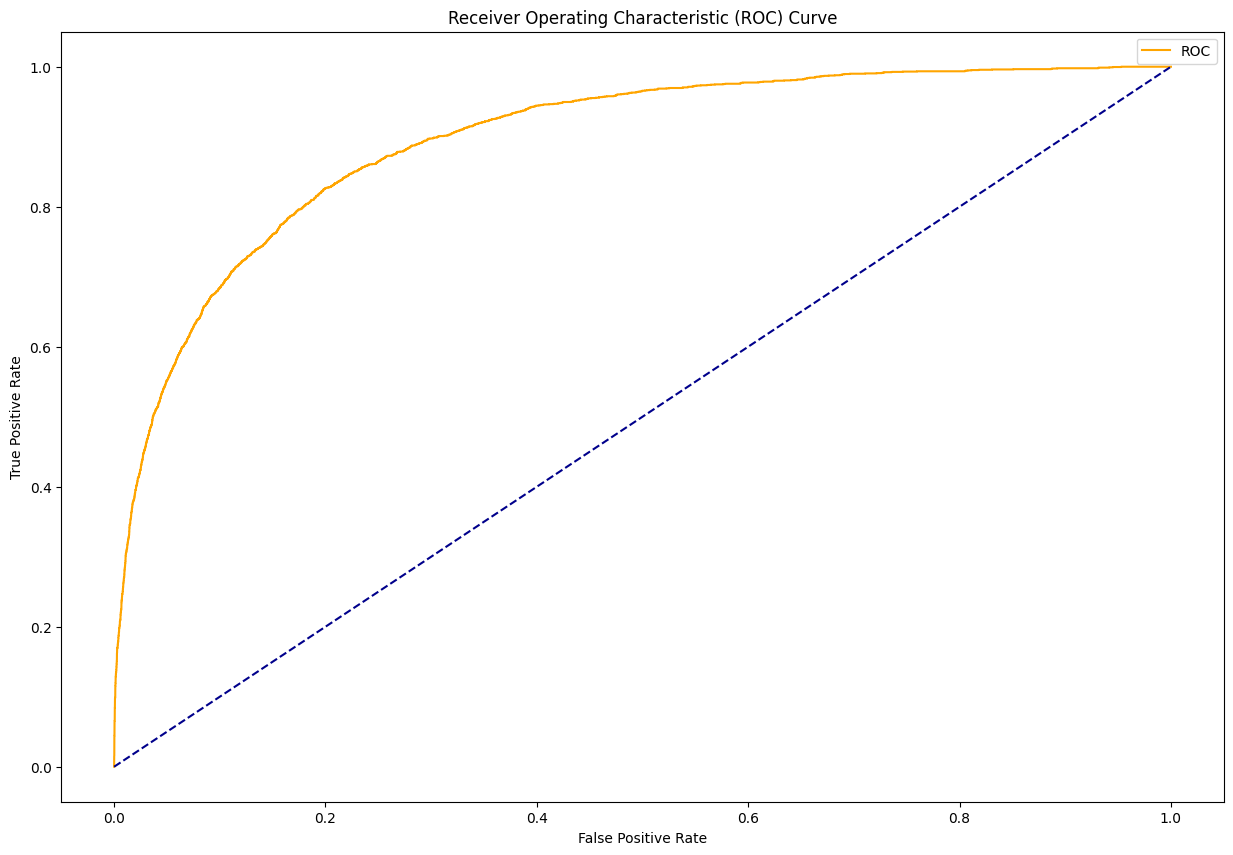

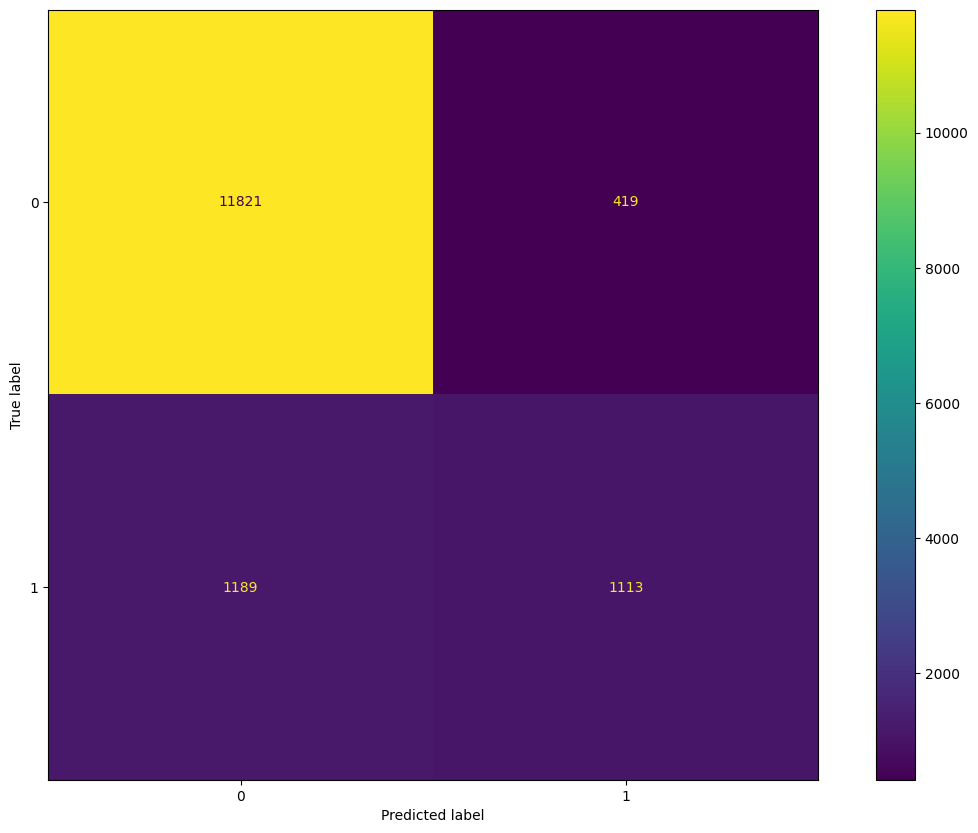

In [14]:
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

Best parameters:  {'n_estimators': 1200, 'max_depth': 16}
Best Score:  0.8842087413420652


<AxesSubplot: >

<Figure size 2000x1500 with 0 Axes>

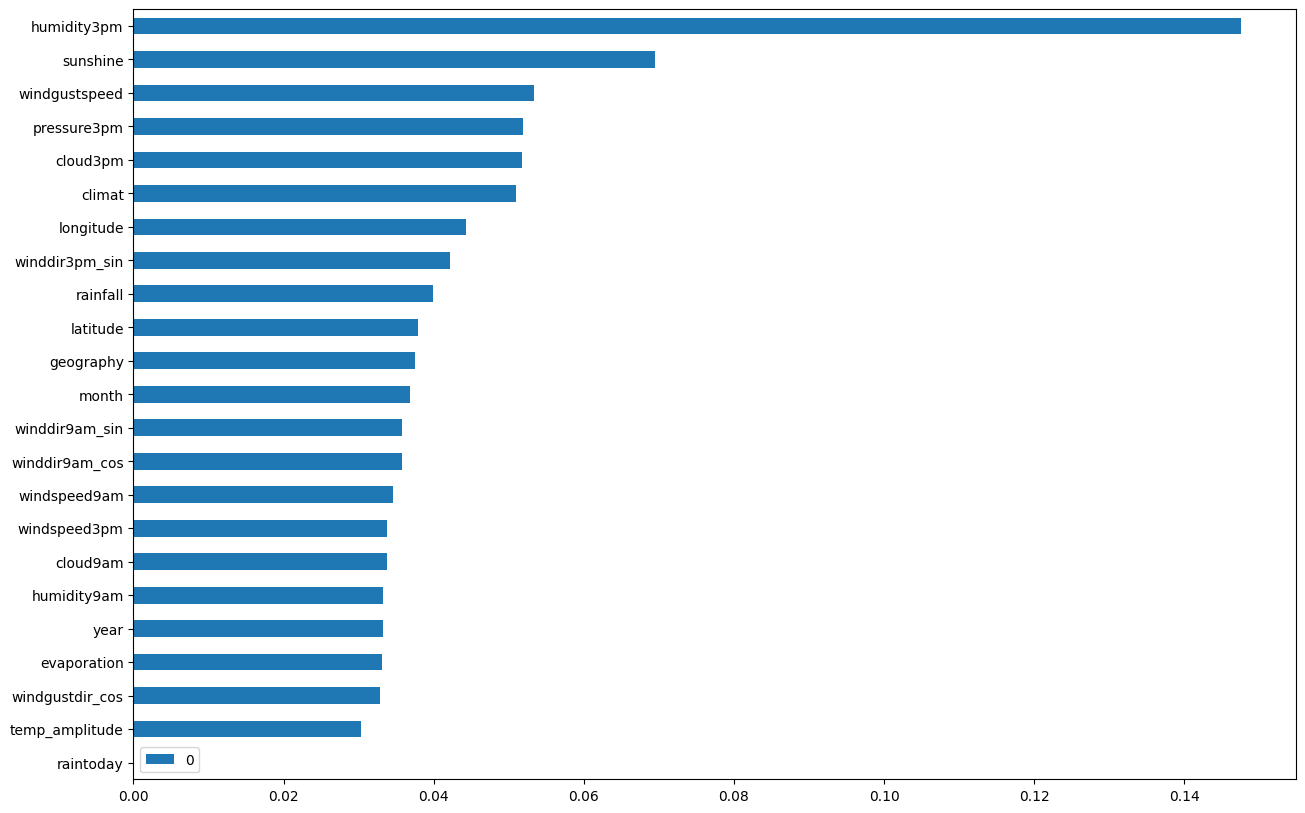

In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': range(15, 20),
    'n_estimators':range(500, 1500,100)
}
clf = xgb.XGBClassifier(eta = 0.1)
randomized_clf = RandomizedSearchCV(estimator=clf,param_distributions=param_grid,scoring = 'accuracy',n_iter = 7, cv = 3, random_state = 42)
randomized_clf.fit(X_train,y_train)

print("Best parameters: ", randomized_clf.best_params_)
print("Best Score: ", randomized_clf.best_score_)
features = pd.DataFrame(randomized_clf.best_estimator_.feature_importances_,index = X_train.columns)
features.sort_values(by = 0, ascending = True, inplace = True)
plt.figure(figsize=(20,15))
features.plot(kind = 'barh')

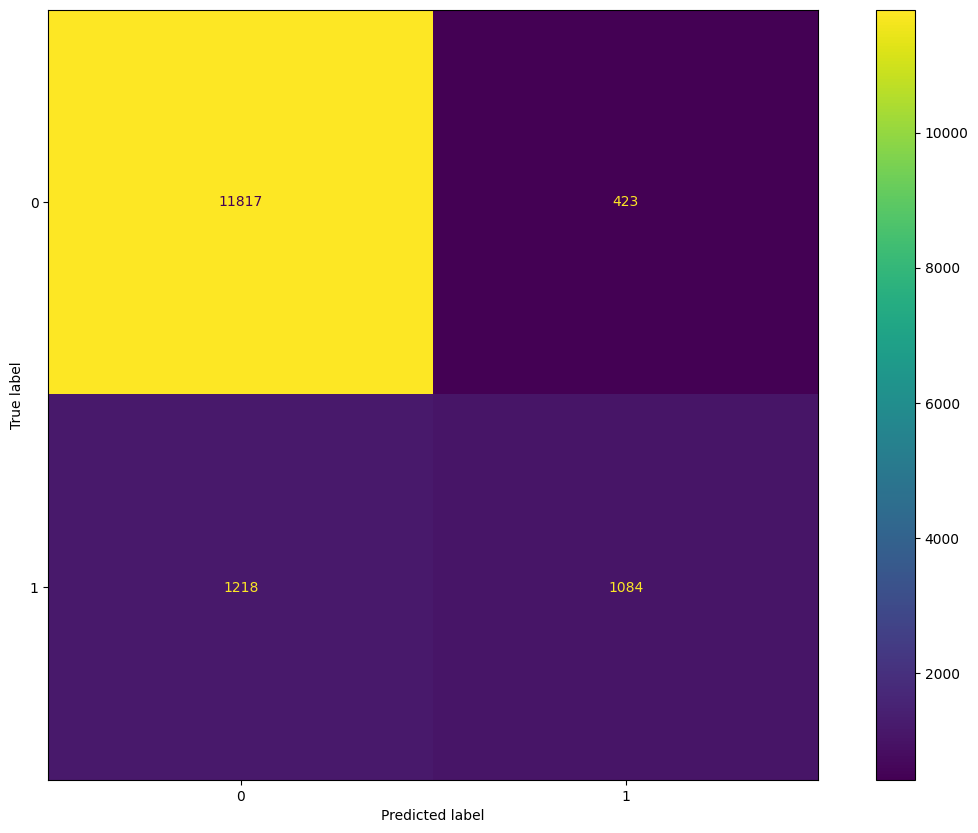

In [22]:
y_pred = randomized_clf.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=randomized_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=randomized_clf.classes_)
disp.plot()
plt.show()
#Best parameters:  {'n_estimators': 1400, 'max_depth': 18}
#Best Score:  0.8672673172800799

Best parameters:  {'n_estimators': 1200, 'max_depth': 16}
Best Score:  0.8842087413420652


<Figure size 2000x1500 with 0 Axes>

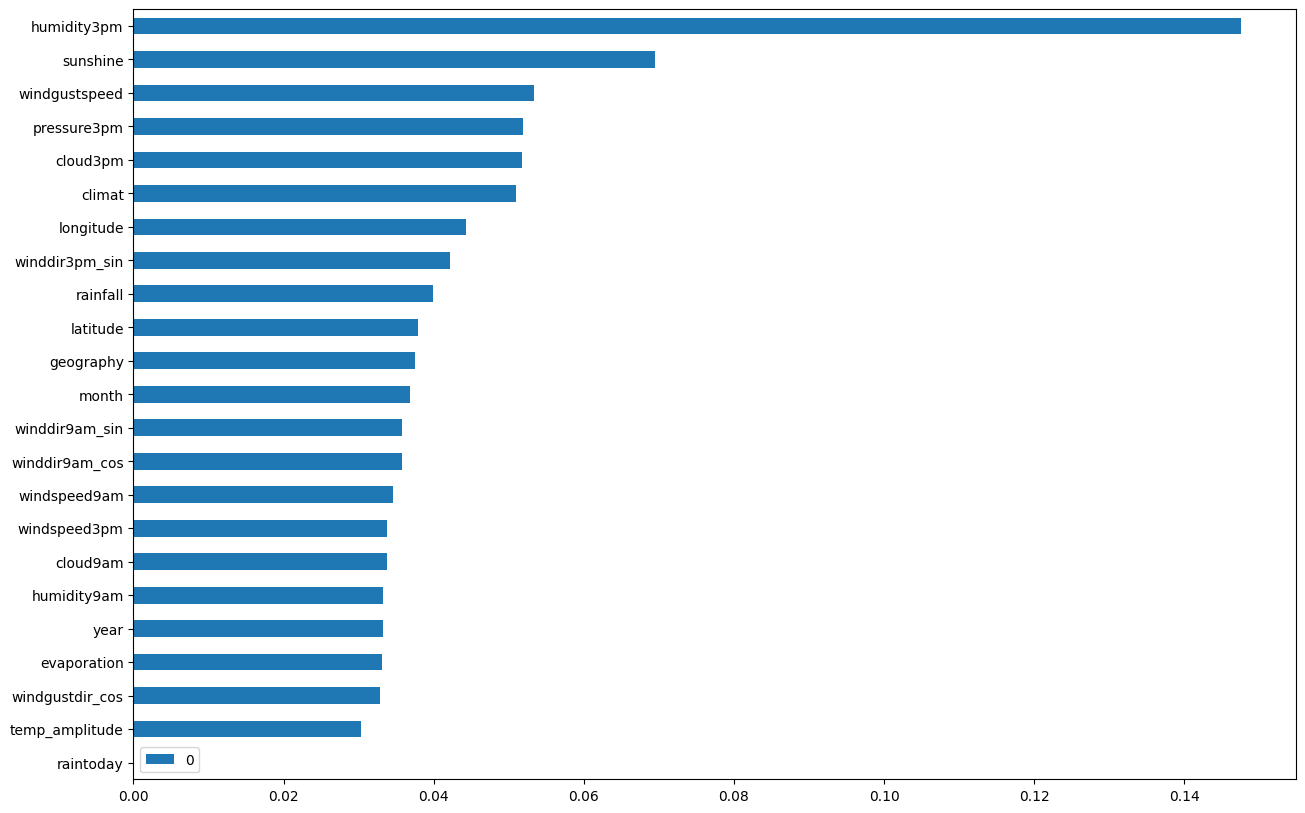

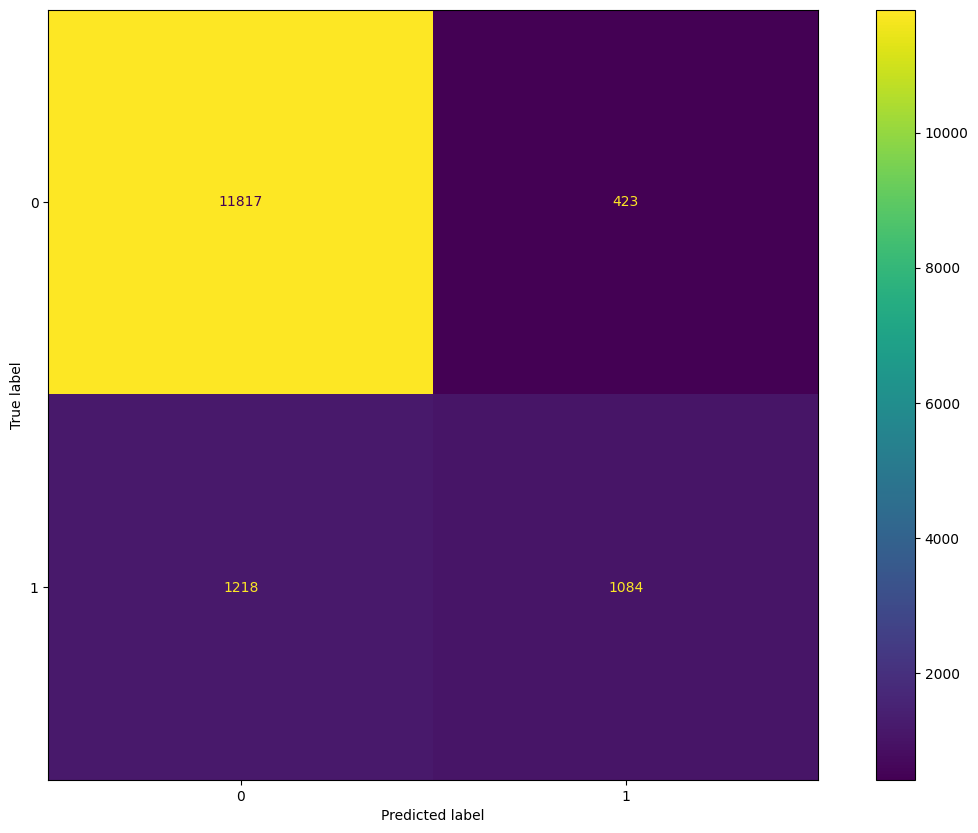

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12240
           1       0.72      0.47      0.57      2302

    accuracy                           0.89     14542
   macro avg       0.81      0.72      0.75     14542
weighted avg       0.88      0.89      0.88     14542



In [23]:
print("Best parameters: ", randomized_clf.best_params_)
print("Best Score: ", randomized_clf.best_score_)
features = pd.DataFrame(randomized_clf.best_estimator_.feature_importances_,index = X_train.columns)
features.sort_values(by = 0, ascending = True, inplace = True)
plt.figure(figsize=(20,15))
features.plot(kind = 'barh')

y_pred = randomized_clf.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=randomized_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=randomized_clf.classes_)
disp.plot()
plt.show()

print(classification_report(y_test,y_pred))

### 2) LogisticRegression

In [24]:
for X_train, y_train, X_test , y_test in zip([X_train],[y_train],[X_test],[y_test]): #la boucle est conservée si jamais on souhaite ajouter un autre dataset tel que pca...
    logistic_params  = {
        "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "penalty" : ['none', 'l1', 'l2', 'elasticnet'],
        'C' : [100, 10, 1.0, 0.1, 0.01],
        "class_weight" :['balanced', None]
    }

    # apply gridsearch model 
    lr_grid = GridSearchCV(LogisticRegression(), logistic_params, scoring = 'accuracy',cv = 4)

    lr_grid.fit(X_train, y_train)
    lr_grid.best_estimator_
    y_pred = lr_grid.predict(X_test)

    best_score = lr_grid.best_score_
    best_params = lr_grid.best_params_
    precision = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'Accuracy =: {round(lr_grid.score(X_train, y_train) * 100, 2)}%')
    print(f'Accuracy =: {round(lr_grid.score(X_test, y_test) * 100, 2)}%')
    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)

Accuracy =: 87.47%
Accuracy =: 87.33%
--
Best Parameters is {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
--
ROC Score is 0.6658690510667054
--
Recall Score is  0.3622936576889661
--
Confusion Matrix

 [[11866   374]
 [ 1468   834]]


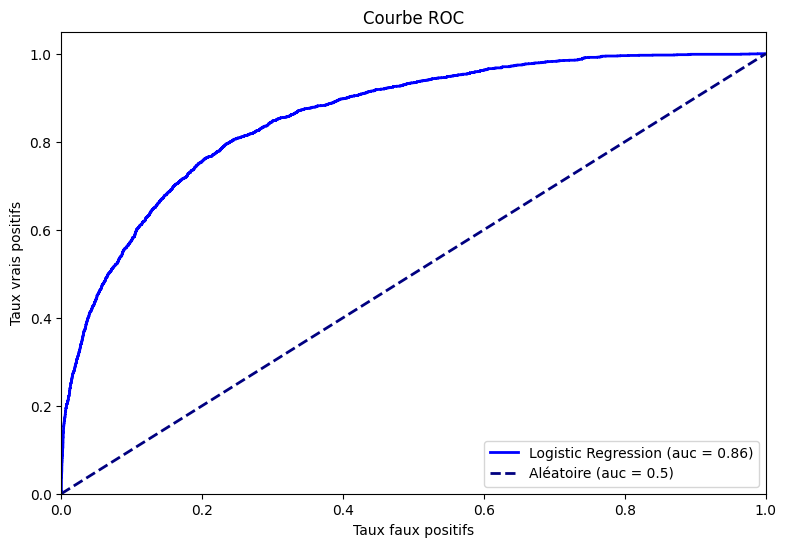

Le score du modèle de régression logistique sur les données de test est : 0.87


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de régression logistique
logreg_clf = LogisticRegression(solver='lbfgs')
logreg_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_logreg = logreg_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_logreg, tpr_logreg, seuils_logreg = roc_curve(y_test,probs_logreg[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Logistic Regression (auc = %0.2f)' % roc_auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Score sur les données de test
score_logreg = logreg_clf.score(X_test, y_test)
print("Le score du modèle de régression logistique sur les données de test est : {:.2f}".format(score_logreg))

### 3) Decision Tree Classification

In [26]:
for X_train, y_train, X_test , y_test in zip([X_train],[y_train],[X_test],[y_test]): #la boucle est conservée si jamais on souhaite ajouter un autre dataset tel que pca...

    tree_params  = {
    "criterion" : ['gini', 'entropy', 'log_loss'],
    "max_depth" : [40,100, None],
    'splitter' : ['best', 'random'],
    'max_features' : ["auto",'sqrt', 'log2',None],
    'random_state' : [4,5],
    'max_leaf_nodes' : [5,10,None],
    'class_weight': ['balanced',None]
    }

    # apply gridsearch model 
    tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring = 'accuracy',cv = 4)

    tree_grid.fit(X_train, y_train)
    tree_grid.best_estimator_
    y_pred = tree_grid.predict(X_test)

    best_score = tree_grid.best_score_
    best_params = tree_grid.best_params_
    precision = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'Accuracy =: {round(tree_grid.score(X_train, y_train) * 100, 2)}%')
    print(f'Accuracy =: {round(tree_grid.score(X_test, y_test) * 100, 2)}%')

    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)

Accuracy =: 86.63%
Accuracy =: 86.28%
--
Best Parameters is {'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'max_leaf_nodes': 10, 'random_state': 4, 'splitter': 'best'}
--
ROC Score is 0.6056551066705281
--
Recall Score is  0.22936576889661164
--
Confusion Matrix

 [[12019   221]
 [ 1774   528]]


In [27]:
#Grille de recherche pour avoir les meilleurs hyperparametres pour le criterion et max_depth.

param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split':[300],'min_samples_leaf':[100]}
nfolds = 3

resc_dt = make_scorer(f1_score,pos_label=1)

# decision tree model
dtree_model=DecisionTreeClassifier()
#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring=resc_dt)
#fit model to data
dtree_gscv.fit(X_train, y_train)

dtree_gscv.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 100,
 'min_samples_split': 300}

In [28]:
#Création de l'arbre avec les meilleurs hyperparametres calcules ci dessus

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=7,random_state=123,)
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=7, random_state=123)

In [29]:
y_pred = dt_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## Méthode 2 : à l'aide de pandas
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Accuracy: 0.8718195571448218


Classe prédite,0,1
Classe réelle,,
0,11908,332
1,1532,770


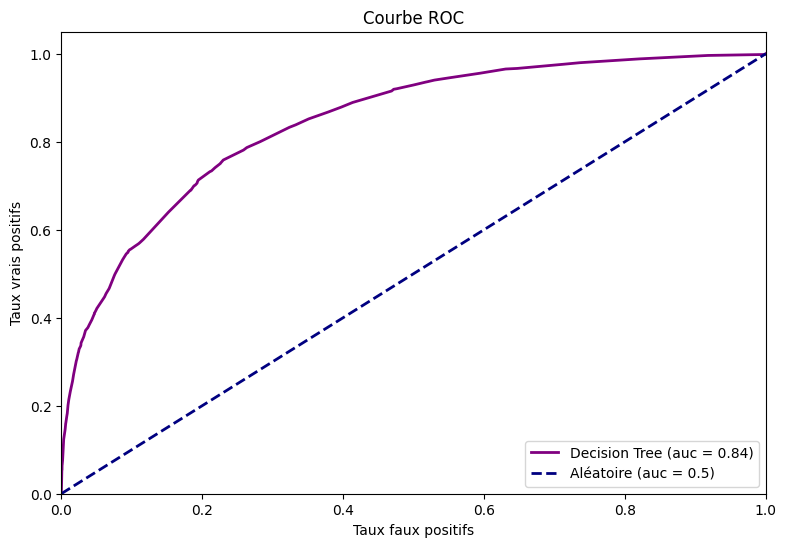

In [30]:
# cette commande permet de tracer et d'évaluer graphiquement la performance d'un modèle de classification binaire, en comparant la courbe ROC du modèle avec celle d'un modèle de classification aléatoire.
# La courbe ROC est utile pour évaluer la performance globale du modèle et pour choisir le seuil de probabilité optimal pour la classification binaire.

probs_dt = dt_clf.predict_proba(X_test)

fpr_dt, tpr_dt, seuils_dt = roc_curve(y_test,probs_dt[:,1],pos_label=1)
#fpr1, tpr1, seuils1 = det_curve(y_test,probs[:,1],pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right");

In [31]:
ac = AdaBoostClassifier(base_estimator=dt_clf,n_estimators=400)
ac.fit(X_train , y_train)
ac.score(X_test, y_test)

0.8701691651767295

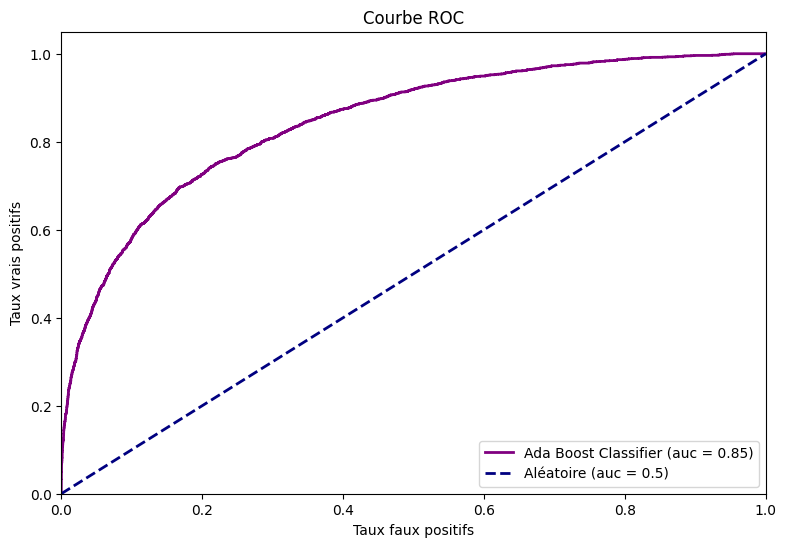

In [46]:
probs_ada = ac.predict_proba(X_test)

fpr_ada, tpr_ada, seuils_ada = roc_curve(y_test,probs_ada[:,1],pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_ada, tpr_ada, color='purple', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

### 4) Support Vector Classification (SVC)

In [32]:
for X_train, y_train, X_test , y_test in zip([X_train],[y_train],[X_test],[y_test]): #la boucle est conservée si jamais on souhaite ajouter un autre dataset tel que pca...

    SVM_params  = {
    #"kernel" : ['rbf'],# 'poly'],#, 'sigmoid'],
    #"degree" : [3,5],
    "C": [10.0, 1.0, 0.1],
    'class_weight': ['balanced',None]
    }

    # apply gridsearch model 
    svm_grid = GridSearchCV(SVC(), SVM_params, scoring = 'accuracy',cv = 4)

    svm_grid.fit(X_train, y_train)
    svm_grid.best_estimator_
    y_pred = svm_grid.predict(X_test)

    best_score = svm_grid.best_score_
    best_params = svm_grid.best_params_
    precision = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)


    print(f'Accuracy =: {round(svm_grid.score(X_train, y_train) * 100, 2)}%')

    print(f'Accuracy =: {round(svm_grid.score(X_test, y_test) * 100, 2)}%')

    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)

Accuracy =: 85.92%
Accuracy =: 85.88%
--
Best Parameters is {'C': 10.0, 'class_weight': None}
--
ROC Score is 0.5613138688721941
--
Recall Score is  0.1259774109470026
--
Confusion Matrix

 [[12199    41]
 [ 2012   290]]


### 5) Random Forest Classifier 

In [33]:
for X_train, y_train, X_test , y_test in zip([X_train],[y_train],[X_test],[y_test]): #la boucle est conservée si jamais on souhaite ajouter un autre dataset tel que pca...

    rfc_params  = {
    'n_estimators': [500,1000,2000],
    'criterion' : ['gini', 'entropy'],
    "class_weight": ['balanced', 'balanced_subsample',None],
    #'max_features': ['auto'],
    #'random_state': [42]
    }

    # apply gridsearch model 
    rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, scoring = 'accuracy',cv = 4)

    rfc_grid.fit(X_train, y_train)
    rfc_grid.best_estimator_
    y_pred = rfc_grid.predict(X_test)

    best_score = rfc_grid.best_score_
    best_params = rfc_grid.best_params_
    precision = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)


    print(f'Accuracy =: {round(rfc_grid.score(X_train, y_train) * 100, 2)}%')

    print(f'Accuracy =: {round(rfc_grid.score(X_test, y_test) * 100, 2)}%')

    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)

Accuracy =: 100.0%
Accuracy =: 88.33%
--
Best Parameters is {'class_weight': None, 'criterion': 'entropy', 'n_estimators': 1000}
--
ROC Score is 0.6781409530218111
--
Recall Score is  0.3779322328410078
--
Confusion Matrix

 [[11975   265]
 [ 1432   870]]


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

In [35]:
# Grille de recherche
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']}

In [36]:
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [37]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [38]:
rfc_best = RandomForestClassifier(**grid_search.best_params_)
rfc_best.fit(X_train, y_train)

RandomForestClassifier(max_features='auto')

In [39]:
score = rfc_best.score(X_test, y_test)
print("Score de précision : {:.2f}".format(score))

Score de précision : 0.88


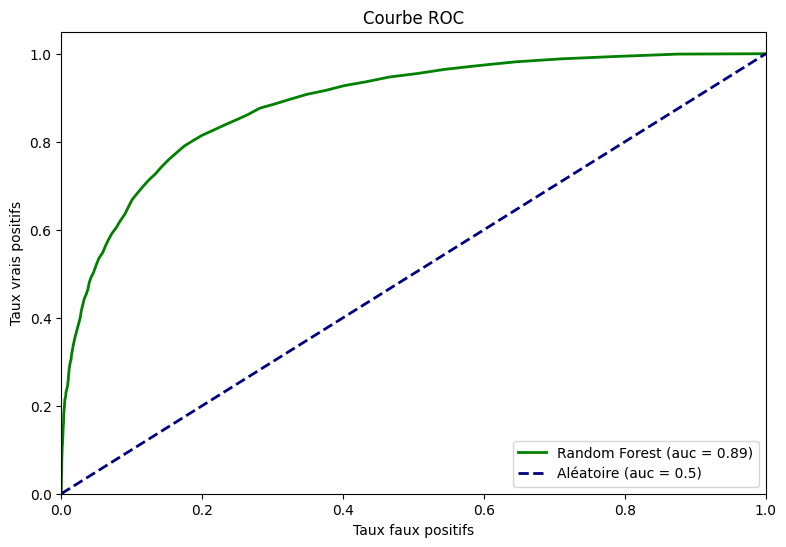

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de forêt aléatoire
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_rf = rf_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_rf, tpr_rf, seuils_rf = roc_curve(y_test,probs_rf[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Tracé de la courbe ROC
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (auc = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [41]:
# Score sur les données de test
score_rf = rf_clf.score(X_test, y_test)

print("Le score du modèle Random Forest sur les données de test est : {:.2f}".format(score_rf))

Le score du modèle Random Forest sur les données de test est : 0.88


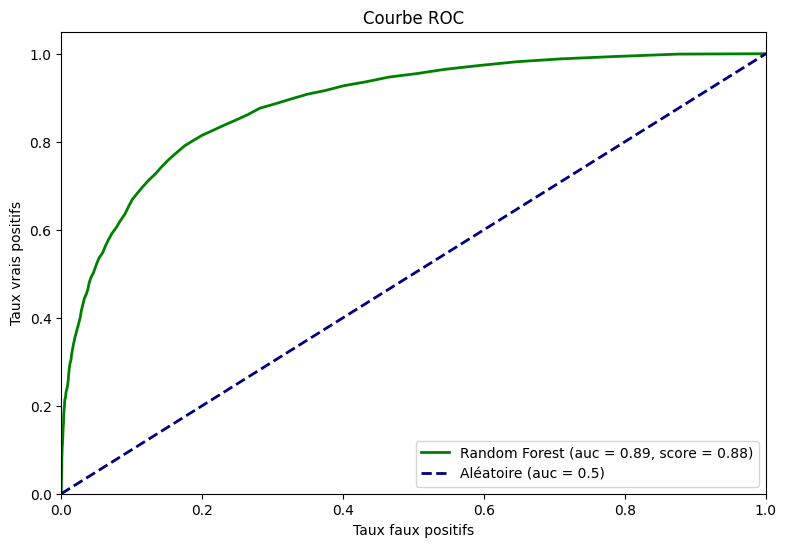

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Création et entraînement d'un modèle de forêt aléatoire
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Prédiction des probabilités des classes pour les données de test
probs_rf = rf_clf.predict_proba(X_test)

# Calcul des taux de faux positifs, des taux de vrais positifs et des seuils correspondants
fpr_rf, tpr_rf, seuils_rf = roc_curve(y_test,probs_rf[:,1],pos_label=1)

# Calcul de l'aire sous la courbe ROC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Score sur les données de test
score_rf = rf_clf.score(X_test, y_test)

# Tracé de la courbe ROC et du score
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (auc = %0.2f, score = %0.2f)' % (roc_auc_rf, score_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

plt.show()


### 6) K-Nearest Neighbors Classifier

In [43]:
for X_train, y_train, X_test , y_test in zip([X_train],[y_train],[X_test],[y_test]): #la boucle est conservée si jamais on souhaite ajouter un autre dataset tel que pca...

    kneig_params  = {
    "n_neighbors" : [5,10,15,20],
    "weights" : ['uniform', 'distance'],
    #'metric' : ['euclidean', 'minkowski']
    }

    # apply gridsearch model 
    kn_grid = GridSearchCV(KNeighborsClassifier(), kneig_params, scoring = 'accuracy',cv = 4)

    kn_grid.fit(X_train, y_train)
    kn_grid.best_estimator_
    y_pred = kn_grid.predict(X_test)

    best_score = kn_grid.best_score_
    best_params = kn_grid.best_params_
    precision = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)


    print(f'Accuracy =: {round(kn_grid.score(X_train, y_train) * 100, 2)}%')

    print(f'Accuracy =: {round(kn_grid.score(X_test, y_test) * 100, 2)}%')

    print ('--')
    print ('Best Parameters is', best_params)
    print ('--')
    print ('ROC Score is', roc)
    print ('--')
    print ('Recall Score is ', recall)
    print ('--')
    print ('Confusion Matrix\n\n', cm)

Accuracy =: 100.0%
Accuracy =: 87.51%
--
Best Parameters is {'n_neighbors': 20, 'weights': 'distance'}
--
ROC Score is 0.6598770321913879
--
Recall Score is  0.34491746307558646
--
Confusion Matrix

 [[11932   308]
 [ 1508   794]]


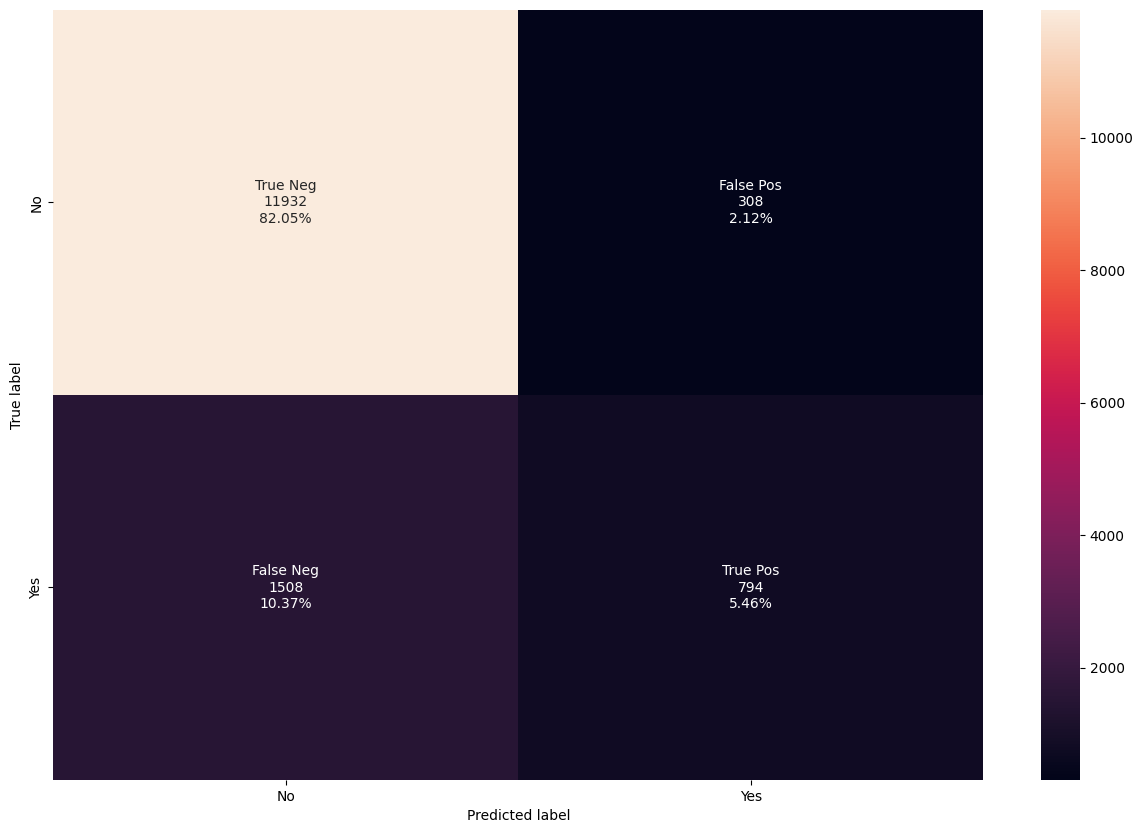

In [45]:
cm = confusion_matrix(y_test,y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

categories = ['No','Yes']


sns.heatmap(cm, annot=labels, fmt='',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()